In [15]:
# === Imports ===
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [4]:
# === Data Loading and Preprocessing ===
print("=== Data Loading and Preprocessing ===")
# Load the tab-separated data
df = pd.read_csv("D:/GIT/Enzyme Classification/Data/Enzyme Data New.tsv", sep='\t')
print(f"Loaded {len(df)} entries from Enzyme Data")

=== Data Loading and Preprocessing ===
Loaded 205003 entries from Enzyme Data


In [6]:
# === Helper Function ===
def extract_class(ec_number):
    """Extract the enzyme class (first digit) from the EC number."""
    if pd.isna(ec_number):
        return np.nan
    # Convert to string and then split
    return int(str(ec_number).split('.')[0])

# Mapping of EC classes to names and functions
ec_class_info = {
    1: {"name": "Oxidoreductases", "function": "Catalyze oxidation-reduction reactions"},
    2: {"name": "Transferases", "function": "Transfer functional groups"},
    3: {"name": "Hydrolases", "function": "Catalyze hydrolysis of various bonds"},
    4: {"name": "Lyases", "function": "Catalyze the breaking of various bonds by means other than hydrolysis and oxidation"},
    5: {"name": "Isomerases", "function": "Catalyze isomerization changes within a single molecule"},
    6: {"name": "Ligases", "function": "Join two molecules with covalent bonds"}
}

def get_class_info(class_number):
    """Get the name and function of the enzyme class."""
    info = ec_class_info.get(class_number, {"name": "Unknown", "function": "Unknown"})
    return info["name"], info["function"]

In [7]:
# Extract class labels from EC number
df['Class'] = df['EC number'].apply(extract_class)

In [8]:
# Validate class labels (should be between 1 and 6)
valid_classes = df['Class'].between(1, 6)
if not valid_classes.all():
    invalid = df[~valid_classes]
    df = df[valid_classes]

print(f"Warning: Found {len(invalid)} with invalid class labels")
print(f"After validation, {len(df)} entries remain")

After validation, 15615 entries remain


In [9]:
# Filter sequences with length >= 3 (required for 3-mers)
df = df[df['Sequence'].apply(len) >= 3]
print(f"After filtering short sequences, {len(df)} entries remain")

After filtering short sequences, 15615 entries remain



=== Exploratory Data Analysis ===


C:\Users\devpa\AppData\Local\Temp\ipykernel_4944\1669971321.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


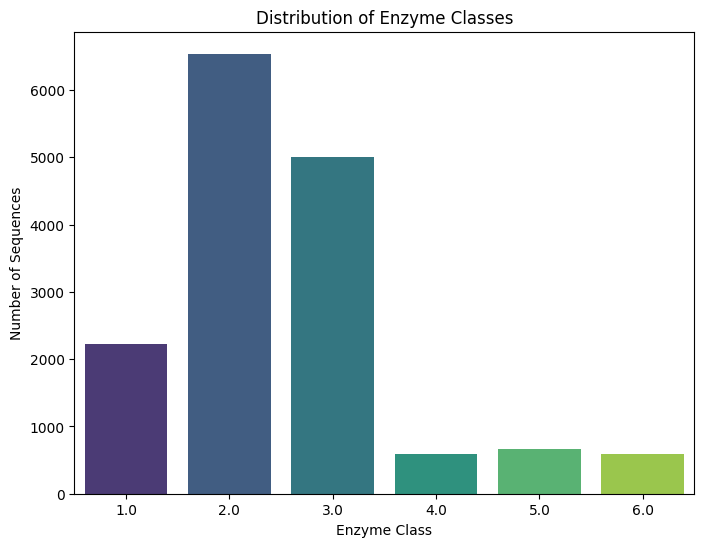

Class distribution plot displayed


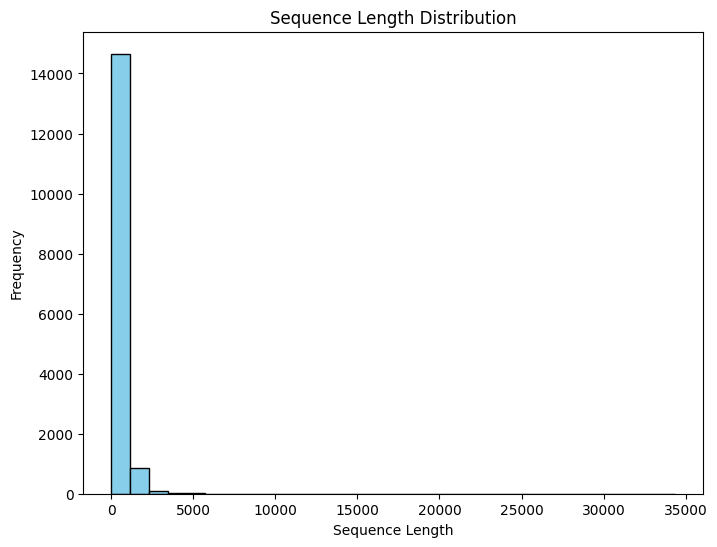

Sequence length distribution plot displayed


In [10]:
# === Exploratory Data Analysis (EDA) ===
print("\n=== Exploratory Data Analysis ===")
# Class distribution
class_counts = df['Class'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Distribution of Enzyme Classes')
plt.xlabel('Enzyme Class')
plt.ylabel('Number of Sequences')
plt.show()
print("Class distribution plot displayed")

# Sequence length distribution
seq_lengths = df['Sequence'].apply(len)
plt.figure(figsize=(8, 6))
plt.hist(seq_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Sequence Length Distribution')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()
print("Sequence length distribution plot displayed")

In [11]:
# === Data Splitting ===
print("\n=== Data Splitting ===")
X = df['Sequence']
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")


=== Data Splitting ===
Training set size: 12492
Testing set size: 3123


In [12]:
# === Feature Extraction ===
print("\n=== Feature Extraction ===")
# Initialize CountVectorizer for 3-mer frequencies
vectorizer = CountVectorizer(analyzer='char', ngram_range=(3, 3), lowercase=False)

# Fit vectorizer on training data only to avoid data leakage
vectorizer.fit(X_train)
print(f"Feature vocabulary size: {len(vectorizer.vocabulary_)} 3-mers")

# Transform sequences to count matrices
X_train_counts = vectorizer.transform(X_train)
X_test_counts = vectorizer.transform(X_test)

# Normalize counts to frequencies (divide by number of 3-mers in each sequence)
X_train_freq = X_train_counts / X_train_counts.sum(axis=1)
X_test_freq = X_test_counts / X_test_counts.sum(axis=1)
print("Feature matrices created with 3-mer frequencies")


=== Feature Extraction ===
Feature vocabulary size: 8872 3-mers
Feature matrices created with 3-mer frequencies


In [13]:
# === Model Training ===
print("\n=== Model Training ===")
clf = RandomForestClassifier(random_state=42, n_jobs=-1)  # Use all CPU cores
clf.fit(X_train_freq, y_train)
print("Random Forest model trained successfully")


=== Model Training ===
Random Forest model trained successfully



=== Model Evaluation ===
Accuracy: 0.8646
Macro Precision: 0.9434
Macro Recall: 0.7880
Macro F1-score: 0.8503

Confusion Matrix:
[[ 337   84   24    0    0    0]
 [   1 1249   56    0    1    1]
 [   0  156  846    0    0    0]
 [   0   28   10   79    0    0]
 [   0   14    9    0  110    0]
 [   0   25   14    0    0   79]]

Classification Report:
              precision    recall  f1-score   support

         1.0       1.00      0.76      0.86       445
         2.0       0.80      0.95      0.87      1308
         3.0       0.88      0.84      0.86      1002
         4.0       1.00      0.68      0.81       117
         5.0       0.99      0.83      0.90       133
         6.0       0.99      0.67      0.80       118

    accuracy                           0.86      3123
   macro avg       0.94      0.79      0.85      3123
weighted avg       0.88      0.86      0.86      3123


ROC AUC Scores (One-vs-Rest):
Class 1.0: 0.9808
Class 2.0: 0.9777
Class 3.0: 0.9798
Class 4.0: 0.9815
C

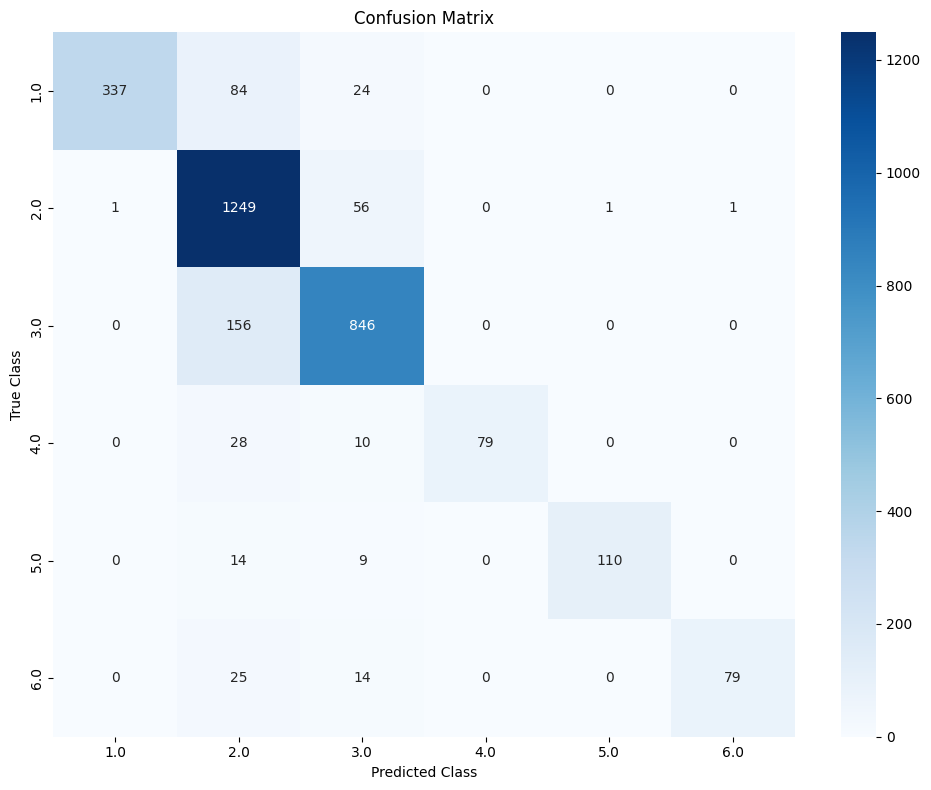

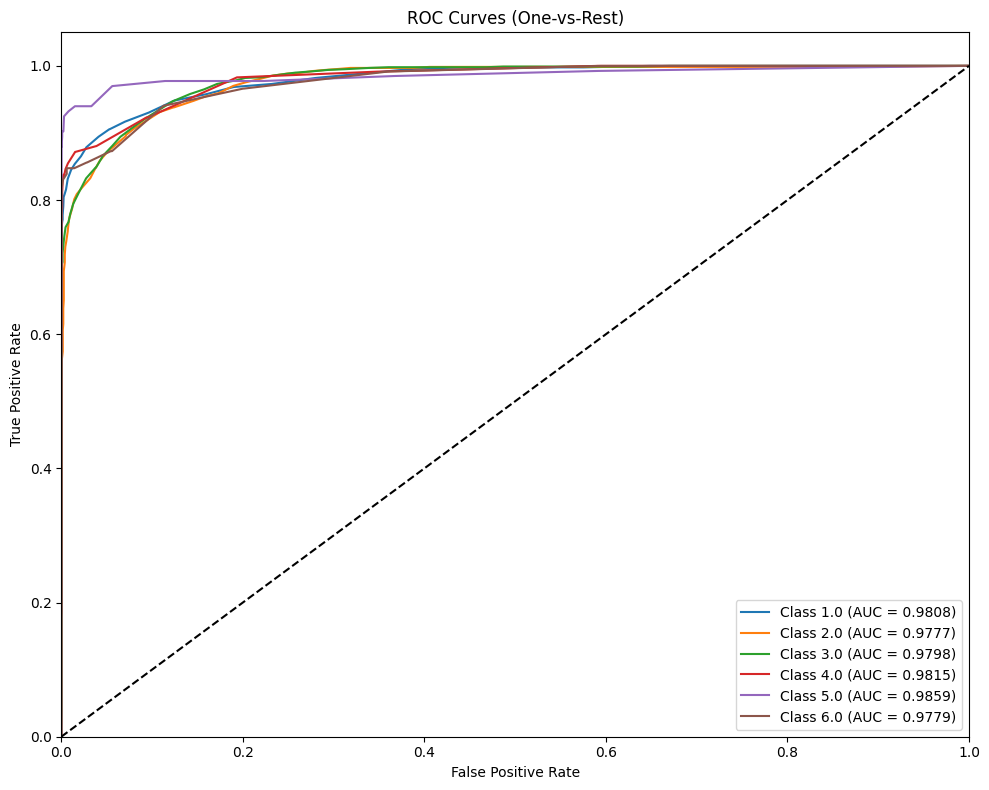

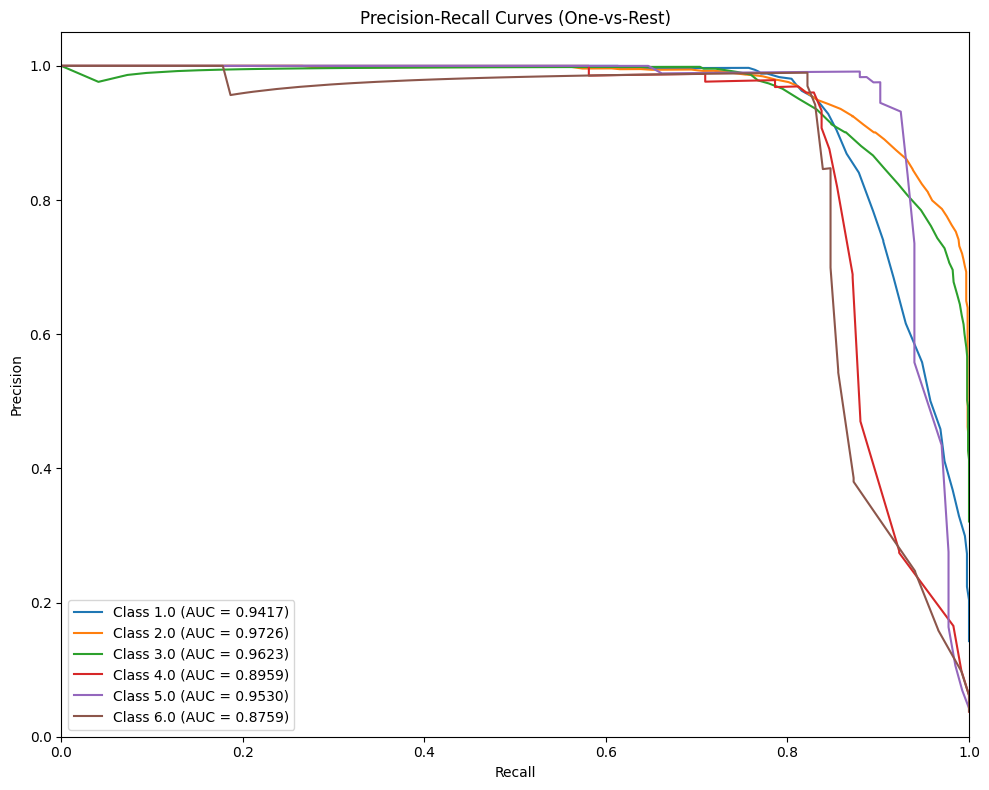


Per-Class Metrics:
Class 1.0:
  Precision: 0.9970
  Recall: 0.7573
  F1 Score: 0.8608
  ROC AUC: 0.9808
  PR AUC: 0.9417
  Average Precision: 0.9378
Class 2.0:
  Precision: 0.8027
  Recall: 0.9549
  F1 Score: 0.8722
  ROC AUC: 0.9777
  PR AUC: 0.9726
  Average Precision: 0.9713
Class 3.0:
  Precision: 0.8822
  Recall: 0.8443
  F1 Score: 0.8628
  ROC AUC: 0.9798
  PR AUC: 0.9623
  Average Precision: 0.9601
Class 4.0:
  Precision: 1.0000
  Recall: 0.6752
  F1 Score: 0.8061
  ROC AUC: 0.9815
  PR AUC: 0.8959
  Average Precision: 0.8856
Class 5.0:
  Precision: 0.9910
  Recall: 0.8271
  F1 Score: 0.9016
  ROC AUC: 0.9859
  PR AUC: 0.9530
  Average Precision: 0.9491
Class 6.0:
  Precision: 0.9875
  Recall: 0.6695
  F1 Score: 0.7980
  ROC AUC: 0.9779
  PR AUC: 0.8759
  Average Precision: 0.8670


In [17]:

# === Model Evaluation ===
print("\n=== Model Evaluation ===")
y_pred = clf.predict(X_test_freq)
y_pred_proba = clf.predict_proba(X_test_freq)

# Calculate basic metrics
accuracy = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')
cm = confusion_matrix(y_test, y_pred)

# Print basic results
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall: {recall_macro:.4f}")
print(f"Macro F1-score: {f1_macro:.4f}")
print("\nConfusion Matrix:")
print(cm)

# Detailed classification report
print("\nClassification Report:")
class_report = classification_report(y_test, y_pred)
print(class_report)

# Calculate ROC AUC score (one-vs-rest)
# First get the list of unique classes
classes = sorted(set(y))
n_classes = len(classes)

# Calculate ROC AUC for each class
roc_auc = {}
for i, class_name in enumerate(classes):
    # Convert to binary classification problem (one-vs-rest)
    y_test_bin = np.array([1 if y == class_name else 0 for y in y_test])
    y_score = y_pred_proba[:, i]
    
    # Calculate ROC AUC
    roc_auc[class_name] = roc_auc_score(y_test_bin, y_score)

# Calculate average ROC AUC
avg_roc_auc = sum(roc_auc.values()) / len(roc_auc)
print(f"\nROC AUC Scores (One-vs-Rest):")
for class_name, score in roc_auc.items():
    print(f"Class {class_name}: {score:.4f}")
print(f"Average ROC AUC: {avg_roc_auc:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()
plt.show()

# Calculate and plot ROC curves
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(classes):
    # Convert to binary classification problem (one-vs-rest)
    y_test_bin = np.array([1 if y == class_name else 0 for y in y_test])
    y_score = y_pred_proba[:, i]
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test_bin, y_score)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'Class {class_name} (AUC = {roc_auc[class_name]:.4f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Calculate and plot Precision-Recall curves
plt.figure(figsize=(10, 8))
avg_pr_auc = {}
for i, class_name in enumerate(classes):
    # Convert to binary classification problem (one-vs-rest)
    y_test_bin = np.array([1 if y == class_name else 0 for y in y_test])
    y_score = y_pred_proba[:, i]
    
    # Calculate precision-recall curve
    precision, recall, _ = precision_recall_curve(y_test_bin, y_score)
    pr_auc = auc(recall, precision)
    avg_pr_auc[class_name] = pr_auc
    
    # Plot precision-recall curve
    plt.plot(recall, precision, label=f'Class {class_name} (AUC = {pr_auc:.4f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves (One-vs-Rest)')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

# Calculate average precision score for each class
avg_precision = {}
for i, class_name in enumerate(classes):
    # Convert to binary classification problem (one-vs-rest)
    y_test_bin = np.array([1 if y == class_name else 0 for y in y_test])
    y_score = y_pred_proba[:, i]
    
    # Calculate average precision score
    avg_precision[class_name] = average_precision_score(y_test_bin, y_score)

# Print per-class metrics
print("\nPer-Class Metrics:")
for i, class_name in enumerate(classes):
    # Convert to binary classification problem (one-vs-rest)
    y_test_bin = np.array([1 if y == class_name else 0 for y in y_test])
    y_pred_bin = np.array([1 if y == class_name else 0 for y in y_pred])
    
    # Calculate precision, recall, f1
    precision = precision_score(y_test_bin, y_pred_bin)
    recall = recall_score(y_test_bin, y_pred_bin)
    f1 = f1_score(y_test_bin, y_pred_bin)
    
    print(f"Class {class_name}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc[class_name]:.4f}")
    print(f"  PR AUC: {avg_pr_auc[class_name]:.4f}")
    print(f"  Average Precision: {avg_precision[class_name]:.4f}")

In [ ]:
# === Save Model and Vectorizer ===
print("\n=== Saving Model and Vectorizer ===")
joblib.dump(clf, "D:/GIT/Enzyme Classification/Model/model.pkl")
joblib.dump(vectorizer, "D:/GIT/Enzyme Classification/Model/vectorizer.pkl")
print("Model saved as 'model.pkl' and vectorizer saved as 'vectorizer.pkl'")


=== Saving Model and Vectorizer ===
Model saved as 'model.pkl' and vectorizer saved as 'vectorizer.pkl'


In [15]:
# === Prediction Function ===
def predict_class(sequence, vectorizer, model):
    """Predict the enzyme class, name, and function for a given protein sequence."""
    if len(sequence) < 3:
        raise ValueError("Sequence must be at least 3 amino acids long")
    counts = vectorizer.transform([sequence])
    freq = counts / counts.sum(axis=1)
    class_number = model.predict(freq)[0]
    class_name, class_function = get_class_info(class_number)
    return {
        "class_number": class_number,
        "class_name": class_name,
        "major_function": class_function
    }

In [17]:
# === Test Prediction ===
print("\n=== Testing Prediction ===")
sample_sequence = "MAAAMDVDTPSGTNSGAGKKRFEVKKWNAVALWAWDIVVDNCAICRNHIMDLCIECQANQASATSEECTVAWGVCNHAFHFHCISRWLKTRQVCPLDNREWEFQKYGH"
predicted_info = predict_class(sample_sequence, vectorizer, clf)
print(f"Sample sequence: {sample_sequence[:50]}... (length: {len(sample_sequence)})")
print(f"Predicted class: {predicted_info['class_number']} ({predicted_info['class_name']})")
print(f"Major function: {predicted_info['major_function']}")


=== Testing Prediction ===
Sample sequence: MAAAMDVDTPSGTNSGAGKKRFEVKKWNAVALWAWDIVVDNCAICRNHIM... (length: 108)
Predicted class: 2.0 (Transferases)
Major function: Transfer functional groups
